##  <font style="color:black">**Curso de Analytics de Imagens e Vídeos**</font>

Aula 08 - Classificação de imagens usando RNAs

## **Exemplo prático**

Criação e treinamento de rede neural com Pytorch

In [1]:
# Importação das bibliotecas

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms

torch.__version__

'2.0.1'

### Funções auxiliares para a execução

In [2]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy()

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

### Base de dados

In [3]:
# Especificando o transformador das imagens para o formato específico do pytorch (média = 0.5 e desvio padrão 0.5)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [4]:
# baixando base de dados de placas de transito
import urllib.request
import os.path
if not os.path.exists("GTSRB_Final_Training_Images.zip"):
    url = ("https://sid.erda.dk/public/archives/"
    + "daaeac0d7ce1152aea9b61d9f1e19370/"
    + "GTSRB_Final_Training_Images.zip")
    filename = "./GTSRB_Final_Training_Images.zip"
    urllib.request.urlretrieve(url, filename)

IMG_SIZE = 28
TEST_SIZE = 0.2

In [5]:
# lê o arquivo e separa os datasets de treinamento e teste
import zipfile
from skimage.transform import resize
from imageio import imread
from PIL import Image

X, Xt, y, yt = list(), list(), list(), list()

archive = zipfile.ZipFile(
          'GTSRB_Final_Training_Images.zip', 'r')
file_paths = [file for file in archive.namelist()
              if '.ppm' in file]

for filename in file_paths:
    with archive.open(filename) as img_file:
        img = Image.open(img_file).convert('L')
    img = np.array(img, dtype=np.uint8)
    img = resize(img,
                 output_shape=(IMG_SIZE, IMG_SIZE),
                 mode='reflect', anti_aliasing=True)

    img = (img * 255).astype(np.uint8)
    img_class = int(filename.split('/')[-2])

    if (hash(filename) % 1000) / 1000 > TEST_SIZE:
        X.append(img)
        y.append(img_class)
    else:
        Xt.append(img)
        yt.append(img_class)


archive.close()

In [6]:
X[0]

array([[ 77,  76,  87, 101, 125, 128, 142, 169, 237, 248, 238, 203, 149,
        145, 176, 215, 239, 232, 200, 151, 100,  97, 106,  93,  79,  73,
         68,  67],
       [ 83,  81,  91, 119, 140, 106, 131, 205, 251, 250, 229, 170, 151,
        172, 182, 205, 231, 240, 229, 178, 117, 101, 105,  98,  84,  76,
         76,  79],
       [ 77,  85,  95, 133, 122, 111, 195, 246, 252, 246, 216, 179, 205,
        222, 178, 177, 216, 236, 243, 209, 145, 119, 111, 103,  90,  74,
         72,  77],
       [ 74,  85, 103, 134, 112, 137, 213, 241, 249, 238, 210, 193, 218,
        232, 222, 195, 196, 216, 215, 212, 172, 113,  93, 116, 110,  76,
         73,  79],
       [ 73,  92, 119, 129, 111, 145, 194, 213, 204, 194, 174, 165, 173,
        172, 160, 151, 144, 138, 125, 126, 113, 100,  89, 100, 118,  82,
         74,  94],
       [ 86, 110, 140, 107, 103, 120, 142, 131, 122, 116, 110, 105, 102,
        102, 101, 100, 101,  98,  98,  96,  96,  97, 107,  95, 107,  80,
         74, 102],
       [12

In [7]:
from torch.utils.data import TensorDataset, DataLoader

tensor_x_treino = torch.from_numpy(np.array(X, dtype=np.uint8)).to(torch.float32)
tensor_x_teste = torch.from_numpy(np.array(Xt, dtype=np.uint8)).to(torch.float32)

tensor_y_treino = torch.from_numpy(np.array(y, dtype=np.uint8)).to(torch.long)
tensor_y_teste = torch.from_numpy(np.array(yt, dtype=np.uint8)).to(torch.long)

dataset_treino = TensorDataset(tensor_x_treino,tensor_y_treino)
dataset_teste = TensorDataset(tensor_x_teste,tensor_y_teste)

trainloader = DataLoader(dataset_treino)
testloader = DataLoader(dataset_teste)

In [8]:
# Visualizando uma imagem percorrendo o dataloader
# (1, 1, 28, 28)

image, label = next(iter(trainloader))
#imshow(image[0])
print(image[0].dtype)

torch.float32


Label	| Description

0	    | T-shirt/top | Camiseta/Blusa

### Criando uma rede neural

In [9]:
# Criação da classe queno formato especificado pelo pytorch
# Classifier é o nome escolhido para a o objeto
# dados de entrada (28x28 = 784)
# RNA totalmente conectada
# saída: 10 classes (camisas, sapatos, etc.)

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        # Camadas lineares para as conexões
        self.fc1 = nn.Linear(784, 256) # camada intermediaria 1
        self.fc2 = nn.Linear(256, 128) # camada intermediaria 2
        self.fc3 = nn.Linear(128, 64)  # camada intermediaria 3
        self.fc4 = nn.Linear(64, 43)   # camada de saida


    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        x = F.relu(self.fc1(x)) # Aplciação da função relu apos o somatório linear
        x = F.relu(self.fc2(x)) # Aplciação da função relu apos o somatório linear
        x = F.relu(self.fc3(x)) # Aplciação da função relu apos o somatório linear

        x = self.fc4(x)         # Não é necessário aplicação da função de ativação na última camada, pois iremos calcular as probabilidades com esta saída

        return x

In [10]:
# Criando objeto da estrutura da rede

net = Classifier()
print(net)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=43, bias=True)
)


In [11]:
# Onde estão os pesos da rede?
# Os pesos estão entre [-1, 1]

print(net.fc1.weight)
print(' ')
print(net.fc1.weight.shape)

Parameter containing:
tensor([[ 0.0073, -0.0343,  0.0130,  ...,  0.0060,  0.0311, -0.0161],
        [-0.0329,  0.0171,  0.0017,  ..., -0.0107,  0.0346,  0.0076],
        [ 0.0346, -0.0338, -0.0145,  ..., -0.0316, -0.0284,  0.0318],
        ...,
        [ 0.0260,  0.0301, -0.0061,  ..., -0.0171, -0.0216,  0.0182],
        [-0.0092,  0.0024, -0.0264,  ...,  0.0321, -0.0027,  0.0045],
        [ 0.0061, -0.0123,  0.0063,  ...,  0.0026,  0.0080, -0.0293]],
       requires_grad=True)
 
torch.Size([256, 784])


In [12]:
# Definindo parâmetros importantes do treinamento
#Função de custo e função de otimização dos parâmetros
# Faz-se necessário passar os parâmetros da rede e a taxa de aprendizado (learning rate)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

### Etapa de treinamento

In [13]:
# verificando disponibilidade da gpu
device = torch.device('cuda') if torch.cuda.is_available else torch.devide('cpu')
device

device(type='cuda')

## Adiciona a rede para a GPU

In [14]:
net.to(device)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=43, bias=True)
)

In [15]:
# Função que define o fluxo de treinamento

def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.

    # loop interno para pegar os batches de imagens
    for i, data in enumerate(loader):

        # pega os dados de entrada e saida
        inputs, labels = data

        # inseri os dados na gpu
        inputs, labels = inputs.to(device), labels.to(device)

        # Zera o gradiente
        optimizer.zero_grad()

        # Passa as imagens na rede e o resultado é armazenado em outputs
        outputs = net(inputs)

        # Calcula o erro do batch
        loss = criterion(outputs, labels)

        # Realiza o backpropagation
        loss.backward()

        # Atualiza os pesos
        optimizer.step()

        # Agrupa o erro do batch
        running_loss += loss.item()

        # Calcula a probabilidade com a função softmax
        ps = F.softmax(outputs)

        # Identifica pelo indice a classe com maior probabilidade para comparar com os labels originais
        top_p, top_class = ps.topk(k = 1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)

        # equals se transforma em um vetor de zeros e ums, logo podemos calcular a acuarcia como abaixo
        accuracy = torch.mean(equals.type(torch.float))

        running_accuracy += accuracy


        # Imprimindo os dados referentes a este batch
        #print(f'\rÉpoca {epoch+1:3d} - Batch {i+1:3d} de {len(loader):3d}: perda {loss:03.2f} - acurácia {accuracy:03.2f}')

    # Imprimindo os dados referentes a esta época
    print(f'\rÉPOCA {epoch+1:3d} FINALIZADA: perda {running_loss/len(loader):.5f} - acurácia {running_accuracy/len(loader):.5f}')

In [16]:
for epoch in range(5):
  print('Treinando...')
  training_loop(trainloader, epoch)
  net.eval()
  print('Testando...')
  training_loop(testloader, epoch)
  net.train()

Treinando...


C:\Users\Igor\AppData\Local\Temp\ipykernel_16684\653912730.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ps = F.softmax(outputs)


ÉPOCA   1 FINALIZADA: perda nan - acurácia 0.15413
Testando...
ÉPOCA   1 FINALIZADA: perda nan - acurácia 0.00454
Treinando...
ÉPOCA   2 FINALIZADA: perda nan - acurácia 0.00556
Testando...
ÉPOCA   2 FINALIZADA: perda nan - acurácia 0.00454
Treinando...
ÉPOCA   3 FINALIZADA: perda nan - acurácia 0.00556
Testando...
ÉPOCA   3 FINALIZADA: perda nan - acurácia 0.00454
Treinando...
ÉPOCA   4 FINALIZADA: perda nan - acurácia 0.00556
Testando...
ÉPOCA   4 FINALIZADA: perda nan - acurácia 0.00454
Treinando...
ÉPOCA   5 FINALIZADA: perda nan - acurácia 0.00556
Testando...
ÉPOCA   5 FINALIZADA: perda nan - acurácia 0.00454


### Avaliação do Modelo

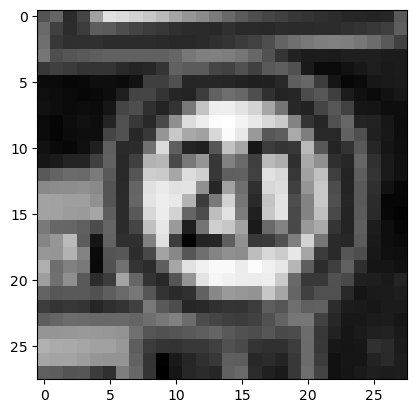

In [17]:
# Percorrendo as imagens do loader de teste e pegando uma imagem unica

imagem = next(iter(testloader))[0][0].view(28,28)
plt.imshow(imagem, cmap='gray')

In [18]:
imagem.shape

torch.Size([28, 28])

In [19]:
# Formatando imagem para o shape requerido pelo pytorch

imagem = imagem.view(1, 1, 28, 28)
imagem.shape

torch.Size([1, 1, 28, 28])

In [20]:
# Colocando a rede no modo eval e passando para gpu

net.eval()
imagem = imagem.to(device)

In [21]:
# Realizando previsão

previsao = net.forward(imagem)

In [22]:
# verificando respostas
# Estes valores são chamados de 'score'.

print(previsao)

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [23]:
# Aplicando softmax nos scores para gerar as probabilidades

prob = F.softmax(previsao, dim=1)

print(prob)

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [24]:
# Selecionando apenas os resultados

prob = prob.cpu().detach().numpy()

print(prob)

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan]]


In [25]:
# verificando o resultado

resultado = np.argmax(prob)

print(f'A classe predita é: {resultado}')

classes = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve to the left",
    20: "Dangerous curve to the right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 metric tons"
}


print('\n Classe: ' + classes[resultado])

A classe predita é: 0

 Classe: Speed limit (20km/h)


0 | Speed limit (20km/h)

1 | Speed limit (30km/h)

2 | Speed limit (50km/h)

3 | Speed limit (60km/h)

4 | Speed limit (70km/h)

5 | Speed limit (80km/h)

6 | End of speed limit (80km/h)

7 | Speed limit (100km/h)

8 | Speed limit (120km/h)

9 | No passing

10 | No passing for vehicles over 3.5 metric tons

11 | Right-of-way at the next intersection

12 | Priority road

13 | Yield

14 | Stop

15 | No vehicles

16 | Vehicles over 3.5 metric tons prohibited

17 | No entry

18 | General caution

19 | Dangerous curve to the left

20 | Dangerous curve to the right

21 | Double curve

22 | Bumpy road

23 | Slippery road

24 | Road narrows on the right

25 | Road work

26 | Traffic signals

27 | Pedestrians

28 | Children crossing

29 | Bicycles crossing

30 | Beware of ice/snow

31 | Wild animals crossing

32 | End of all speed and passing limits

33 | Turn right ahead

34 | Turn left ahead

35 | Ahead only

36 | Go straight or right

37 | Go straight or left

38 | Keep right

39 | Keep left

40 | Roundabout mandatory

41 | End of no passing

42 | End of no passing by vehicles over 3.5 metric ton